In [1]:
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import tidetools
from salishsea_tools import (nc_tools,viz_tools)
import matplotlib.cm as cm
import os
%matplotlib inline

In [2]:
grid1 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc','r')

In [3]:
f1 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane\
/result/14_NW_deepen/ariane_trajectories_qualitative.nc','r')
f2 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane\
/result/default/ariane_trajectories_qualitative.nc','r')

In [4]:
def compare_tracks_more(f1,f2,grid1,grid2,i):
    """This function was made to compare particle trajectories
        between nowcasts & deepened case and nowcasts with same 
        TS initial & deepended case
        f1: deepened case
        f2: nowcasts 
        f3: nowcasts with same TS for deepend case
        return the figure"""
    fig, axs = plt.subplots(1,1,figsize=(6,6))
    n = np.arange(2)
    #grid = [grid1, grid2]
    colors = cm.rainbow(np.linspace(0, 1, len(n)))
    legd = ['new', 'nowcast']
    ## for first comparison
    f = [f1,f2]
    for ff, le, c in zip(f, legd, colors):
        lont = ff.variables['traj_lon']
        latt = ff.variables['traj_lat']
        dept = ff.variables['traj_depth']
        xs = ff.variables['init_x']
        ys = ff.variables['init_y']
        t = ff.variables['traj_time']
        axs.scatter(lont[1:,i],latt[1:,i],color=c, label = le)
        axs.scatter(lont[0,i],latt[0,i],color='0.30',marker='s')
        axs.legend(loc = 2)
        #viz_tools.plot_land_mask(axs, grid1, coords='map')
        viz_tools.plot_coastline(axs,grid1,coords='map', isobath=5)
        axs.set_xlim([-123.8,-122.8])
        axs.set_ylim([48.5,49.4])
        axs.set_xlabel('longitude')
        axs.set_ylabel('latitude')
    return fig

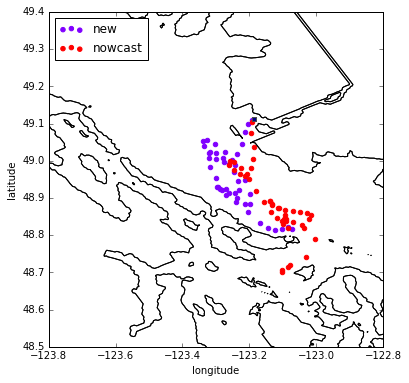

In [5]:
fig = compare_tracks_more(f1,f2, grid1,grid2, 0)

# Drifter

In [6]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy, X, Y = tidetools.get_bathy_data(grid)
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']
bath = grid.variables['Bathymetry']

In [7]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']

In [8]:
def plotoct_mewold(lon,lat,part,start,end,start_d,end_d,day,hour,minute,duration):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    viz_tools.plot_coastline(axs,grid,coords='map')
    viz_tools.plot_coastline(axs,grid,coords='map',isobath=4,color='DarkViolet')
    viz_tools.plot_coastline(axs,grid,coords='map',isobath=20,color='OrangeRed')
    axs.set_xlim([-123.6,-123])
    axs.set_ylim([48.8,49.4])
    axs.set_xticks([-123.6, -123.4, -123.2,-123])
    axs.set_xticklabels([-123.6, -123.4, -123.2,-123])
    axs.set_xlabel('Longitude')
    axs.set_ylabel('Latitude')
    
    colors=['g','DodgerBlue','tomato','Olive']
    for i, key in enumerate(lon.keys()):
        axs.scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[i],label=key)
        axs.scatter(lon[key][0,part],lat[key][0,part],color='0.30',marker='s')
    axs.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5, fancybox=False, shadow=True)
    
    return fig

In [9]:
drop = 'drop1/12'
runs=['oct8_10RFdailySmoo','oct8_10reduceviscosity','oct8_101e061e05','oct8_10']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon112 = {}; lat112={}
for run in runs:
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon112[run] = f.variables['traj_lon']
    lat112[run] = f.variables['traj_lat']

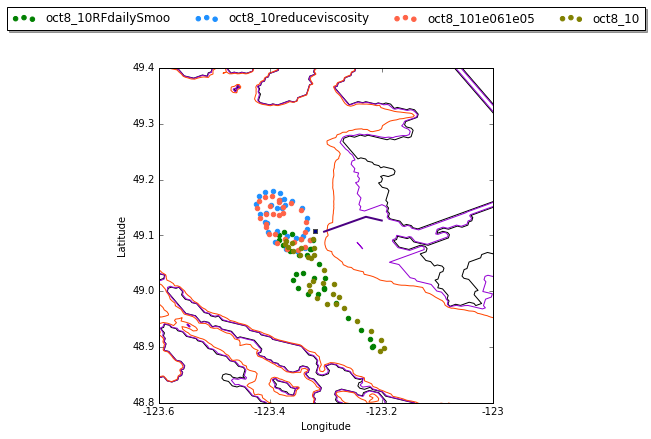

In [10]:
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)

# Salinity stuff

In [11]:
import sys
sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import salinity3
import datetime
import scipy.io as sio
import numpy as np
import netCDF4 as nc
import matplotlib.gridspec as gridspec

In [12]:
paths = {'nowcast': '/data/jieliu/MEOPAR/river-treatment/oct8_10nowcast/',
        'deepenresult': '/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/',
        'reduced_viscosity': '/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/',
        'all_reduced': '/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/',
        'jetty': '/data/jieliu/MEOPAR/river-treatment/oct8_10jetty1e0605/'}

In [20]:
def salinity_plot_test(run_date, saline, run_lower, run_upper, path_ssh,t):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_deep, value_mean_4rd_deep, \
    value_mean_avedeep, value_mean_ave4deep,\
    salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn\
    (saline, run_date, paths['deepenresult'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_nowcast, value_mean_4rd_nowcast, \
    value_mean_ave3nowcast, value_mean_ave4nowcast,\
    salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn\
    (saline, run_date, paths['nowcast'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_redu, value_mean_4rd_redu, \
    value_mean_averedu, value_mean_ave4redu,\
    salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn\
    (saline, run_date, paths['reduced_viscosity'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_allredu, value_mean_4rd_allredu, \
    value_mean_aveallredu, value_mean_ave4allredu,\
    salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn\
    (saline, run_date, paths['all_reduced'],run_lower,run_upper)
    

    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    gs.update(wspace=0.17, hspace=0.3)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    titles = '1.5 m Salinity ';
    nowcast = [value_mean_3rd_nowcast, value_mean_ave3nowcast];
    deep = [value_mean_3rd_deep, value_mean_avedeep];
    redu = [value_mean_3rd_redu, value_mean_averedu];
    allredu = [value_mean_3rd_allredu, value_mean_aveallredu];

    ## 1.5m salinity comparison
    model_3rd_nowcast=ax0.plot(lon_model,value_mean_3rd_nowcast,'DodgerBlue',\
                                        linewidth=2, label='nowcast')
    model_3rd_deep=ax0.plot(lon_model,value_mean_3rd_deep,'MediumBlue',\
                                            linewidth=2, label="deepened" )
    model_3rd_redu=ax0.plot(lon_model,value_mean_3rd_redu,'tomato',\
                                            linewidth=2, label="reduced_viscosity" )
    model_3rd_allredu=ax0.plot(lon_model,value_mean_3rd_allredu,'Indigo',\
                                            linewidth=2, label="all_redu" )

    observation_salinity=ax0.plot(lon1_model,salinity1_2_4,'DarkGreen', \
                                         linewidth=2, label="Observed")

    ax = ax0
    ax.set_xlim(-124, -123)
    ax.set_ylim(0, 30)
    ax.set_xlabel('Longitude', fontsize = 12)
    ax.set_ylabel('Practical Salinity', fontsize = 12)
    ax.legend(loc = 3,fontsize = 12)
    ax.grid('on')
    ax.set_title(titles + date_str, fontsize = 12)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    ## add ssh plot
    ssh,tt, hour = salinity3.get_ssh_in_model(run_date, path_ssh,t)
    ax1.plot(tt[:],ssh[:, 466,329],'-k', linewidth = 2.5)
    ax1.plot(tt[t],ssh[t, 466,329], color = 'Maroon',marker='*', markersize = 14)
    ax1.grid('on')
       
    #ax1.set_title('Modelled water level at Point Atkinson on '\
                                      # + hour.strftime('%d-%b-%Y %H:%M'), fontsize=16)
    ax1.set_xlabel('Time [utc]',  fontsize=12)
    ax1.set_ylabel('Water level (m)',fontsize=12)
    plt.setp(ax1.get_xticklabels(), fontsize=12)
    plt.setp(ax1.get_yticklabels(), fontsize=12)
    return fig 

In [14]:
run_date = datetime.datetime(2014,10,8)
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141007.mat')

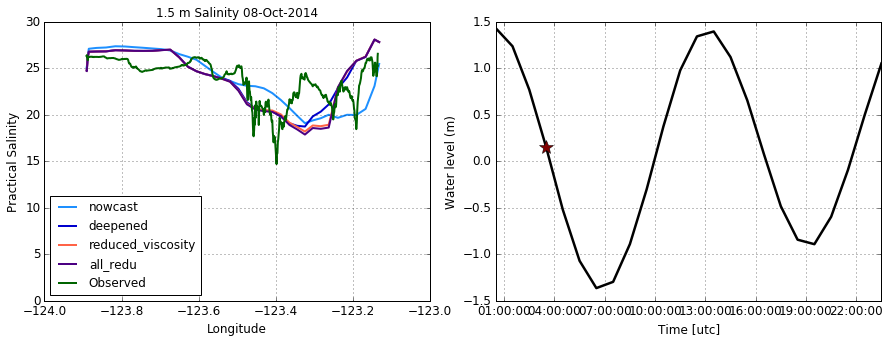

In [21]:
run_lower = run_date.replace(hour = 3, minute = 15)
run_upper = run_date.replace(hour = 5, minute =45)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['deepenresult'],3)

# Statistics

In [16]:
def min_salinity_test(results_home):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    days = [7,8,9];sal_min_obs = [np.nan]; lon_obs = [np.nan];sal_min_15 = [np.nan];lon_15=[np.nan];
    for day in days:
        for i in np.arange(24):
            if i < 12:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE192014100%s.mat' %(day))
            elif i>=12 and day!=9:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE192014100%s.mat' %(day+1))
            elif i>=12 and day ==9:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE19201410%s.mat' %(day+1))
            ## read in run_date, run_lower and run_upper for each trip case.
            run_date = datetime.datetime(2014,10,day+1)
            if i == 0 or i==14 or i==16 or i==21:
                run_lower = run_date.replace(hour = i, minute = 45)
                if i ==14:
                    run_upper = run_lower.replace(hour = i+2)
                if i==21:
                    run_upper = run_date.replace(day = day+2,hour = 0, minute = 45)
                else:
                    run_upper = run_lower.replace(hour = i +3, minute = 15)
            if i ==3 or i==5 or i==19:
                run_lower = run_date.replace(hour = i, minute = 15)
                run_upper = run_lower.replace(hour = i+2, minute = 45)
            ##extract values from ferry route   
            if i == 0 or i==14 or i==16 or i==21 or i ==3 or i==5 or i==19:
                lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_3rd_deep, value_mean_4rd_deep, \
                value_mean_avedeep, value_mean_ave4deep,\
                salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn_norm\
                (saline, run_date, results_home,run_lower,run_upper)
            ## find min salinity value and location along ferry route   
                salinity_min_obs, lon_min_obs, salinity_min_15,\
                lon_min_15, salinity_min_ave, lon_min_ave = salinity3.find_min_value_location\
                (run_date, results_home, saline, run_lower, run_upper,lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_3rd_deep, value_mean_4rd_deep, \
                value_mean_avedeep, value_mean_ave4deep,\
                salinity11, salinity1_2_4, date_str)
            else: 
                salinity_min_obs= np.nan;lon_min_obs=np.nan;salinity_min_15=np.nan;lon_min_15=np.nan
            ## append the values to a list
            sal_min_obs.append(salinity_min_obs);
            lon_obs.append(lon_min_obs);
            sal_min_15.append(salinity_min_15);
            lon_15.append(lon_min_15);
    ##define t
    file = nc.Dataset(results_home+'SalishSea_1h_20141008_20141010_grid_T.nc')
    timesteps = file.variables['time_counter'][:]
    t_t = nc_tools.timestamp(file, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t)         
    return sal_min_obs, lon_obs, sal_min_15,lon_15,tt   

In [17]:
## nowcast case
sal_min_obs,lon_obs,sal_now,lon_now,tt = min_salinity_test(paths['nowcast'])
## reduce viscosity
sal_min_obs,lon_obs,sal_redu,lon_redu,tt = min_salinity_test(paths['reduced_viscosity'])
## reduce both
sal_min_obs,lon_obs,sal_allredu,lon_allredu,tt = min_salinity_test(paths['all_reduced'])
## only long river case
sal_min_obs,lon_obs,sal_deep,lon_deep,tt = min_salinity_test(paths['deepenresult'])

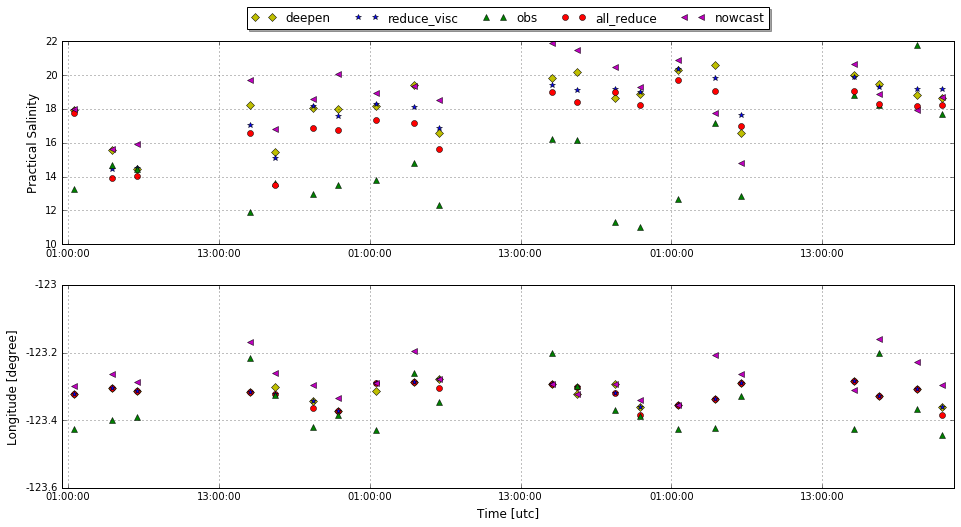

In [19]:
fig, axs = plt.subplots(2,1,figsize = [16,8])
axs[0].plot(tt,sal_deep[:-1],'yD',label = 'deepen')
axs[0].plot(tt,sal_redu[:-1],'b*',label = 'reduce_visc')
axs[0].plot(tt,sal_min_obs[:-1],'g^',label = 'obs')
axs[0].plot(tt,sal_allredu[:-1],'ro',label = 'all_reduce')
axs[0].plot(tt,sal_now[:-1],'m<',label = 'nowcast')
axs[0].set_ylabel('Practical Salinity', fontsize= 12)

axs[1].plot(tt,lon_deep[:-1],'yD',label = 'deepen')
axs[1].plot(tt,lon_allredu[:-1],'ro',label = 'all_reduce')
axs[1].plot(tt,lon_redu[:-1],'b*',label = 'reduce_visc')
axs[1].plot(tt,lon_obs[:-1],'g^',label = 'obs')
axs[1].plot(tt,lon_now[:-1],'m<',label = 'nowcast')
axs[1].set_ylabel('Longitude [degree]', fontsize= 12)
axs[1].set_ylim(-123.6, -123)
axs[1].set_yticks([-123.6, -123.4, -123.2,-123])
axs[1].set_yticklabels([-123.6, -123.4, -123.2,-123])
axs[1].set_xlabel('Time [utc]', fontsize= 12)
for ax in axs:
    #ax.legend(loc = 'best', fontsize= 14)   
    ax.set_xlim(tt[0],tt[-1])
    ax.grid('on')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5, fancybox=False, shadow=True)